# Implementation of SoftMax Parameterizations for Policy Gradient: With constant and time-variant step-size

## Import required libraries


In [1]:
import MarkovDP as mdp            #Imported the MDP class directly
import policyiteration as pi      #Imported Policy Iteration and its utility functions directly
from policyiteration import evaluate_policy
import mdptoolbox.example
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

## List of Functions to be implemented


-Policy Parameterization </br>
-Gradient Calculation </br>
-Policy Update with constant step size </br>
-Policy Update with time variant step size </br>
-Compute State visitation probability disribution </br>
-Plot </br>

## SoftMax Parameterization
### p(a,s) =  $\frac{e ^{\pi(a,s)}}{\sum_{ a' \in A} e ^{\pi(a,s)}}$

In [2]:
def softmax(env,pi_theta):
    pi = np.zeros((env.num_state,env.num_action),dtype=float)
    for s in env.states:
        pi[s]=np.exp(pi_theta[s])
        pi[s]=pi[s]/np.sum(pi[s])
    return np.array(pi)

## Find transition matrix P(s'|s) under policy pi

In [3]:
def P_matrix(env,pi):
    # Compute Transition probabilities P(s,s') using P(s'| s,a ) and pi( a|s ) : Matrix of size |s| x |s|
    P=np.empty((env.num_state,env.num_state),dtype=float)
    P=np.multiply(np.reshape(pi[:,0],(-1,1)),env.transitions[0][:][:])
    for a in range(1,env.num_action):
        P=P+np.multiply(np.reshape(pi[:,a],(-1,1)),env.transitions[a][:][:])
    return P
        

## Find d<sup>$\pi\$</sup>(s) : discounted transition probability


In [4]:
def d_pi_s(env,P,gamma,s):
    e_s=np.zeros((env.num_state,1))
    e_s[s]=1
    i= np.identity(env.num_state)- gamma*(P)
    d= (1-gamma) * np.dot(np.linalg.inv(i),e_s)
    return d

## Gradient Calculation

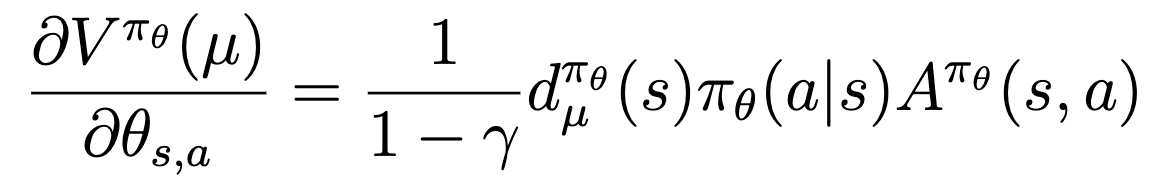

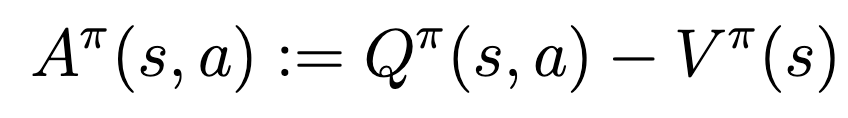

In [5]:
def grad(env,gamma,rho,pi_theta,theta):
    V_grad = np.zeros((env.num_state,env.num_action))
    pi = softmax(env,pi_theta)
    #print(pi_theta)
    P = P_matrix(env,pi)
    V = evaluate_policy(env, pi, gamma, theta)
    #print(V_grad[0][1])
    for s in range(0,env.num_state):
        d=d_pi_s(env,P,gamma,s)
        d_rho= np.dot(rho,d)
        for a in range(0,env.num_action):
            transitions = np.reshape(env.transitions[a][s][:],(-1,1))
            rewards = np.reshape(env.rewards[a][s][:],(-1,1))
            q=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
            advantage=q-V[s]
            V_grad[s][a]= (d_rho*advantage*pi[s][a])/(1-gamma)
    
    
    return V_grad
            
        

## Policy Update


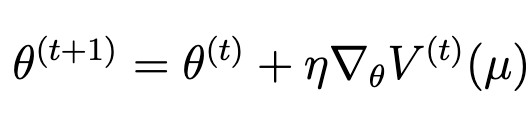

### Constant step size

In [1]:
def policy_gradient_constant_step(env,gamma,theta,rho,iterations,learning_rate,V_rho_optimal):
    pi_theta = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    min_list=list()
    min_t = (V_rho_optimal-np.dot(rho,V)[0]) #Save value function history to observe the convergence
    min_list.append(min_t)
    for i in range(0,iterations):
        V_grad=grad(env,gamma,rho,pi_theta,theta)  #Compute gradient
        for s in env.states:
            pi_theta[s]= pi_theta[s]+ learning_rate * V_grad[s]  #update policy parameters
        pi = softmax(env,pi_theta)  #obtain policy from the parameters
        V=evaluate_policy(env, pi, gamma, theta) 
        min_t=min(min_t,(V_rho_optimal-np.dot(rho,V)[0]))
        min_list.append(min_t)
    return pi,V,min_list
        

### Time variant step size : 1/t<sup>$\alpha\$</sup>

In [2]:
def policy_gradient_variant_step(env,gamma,theta,rho,iterations,V_rho_optimal,alpha):
    pi_theta = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    min_list=list()
    min_t = (V_rho_optimal-np.dot(rho,V)[0])  #Save value function history to observe the convergence
    min_list.append(min_t)
    learning_rate = 1
    for i in range(0,iterations):
        if i==0:
            pass
        elif i%10==0:
            learning_rate= 1/(np.power(i,alpha))
        V_grad=grad(env,gamma,rho,pi_theta,theta) #Compute gradient
        for s in env.states:
            pi_theta[s]= pi_theta[s]+ learning_rate * V_grad[s] #update policy parameters
        pi = softmax(env,pi_theta)  #obtain policy from the parameters
        V=evaluate_policy(env, pi, gamma, theta) 
        min_t=min(min_t,(V_rho_optimal-np.dot(rho,V)[0]))
        min_list.append(min_t)
    return pi,V,min_list
        

## Plot log(min(V<sup>*</sup> - V<sup>t</sup>)) vs log(t)

In [8]:
def plot_log(min_list,iterations):
    
    x=np.log(np.array(range(1,iterations)))
    y=np.log(np.array(min_list)[2:])
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('log(t)', fontsize=12)
    plt.ylabel('log(min(V_opt-V(t)))', fontsize=12)
    plt.plot(x,y,color='blue', label='Policy Iteration') 
    #plt.title(title,fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

## Plot log(min(V<sup>*</sup> - V<sup>t</sup>)) vs t


In [9]:
def plot_antilog(min_list,iterations):
    
    x=(np.array(range(1,iterations)))
    y=np.log(np.array(min_list)[2:])
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('t', fontsize=12)
    plt.ylabel('log(min(V_opt-V(t)))', fontsize=12)
    plt.plot(x,y,color='blue', label='Policy Iteration') 
    #plt.title(title,fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

# Example 1 (s,a)=(3,2)

In [10]:
'''
Define an MDP Environment : Insantiate Class
    Number of states : s
    Number of actions : a
'''

s=3
a=2
env1= mdp.MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
env1.initialize_mdp()    #Define P and R

In [15]:
gamma = 0.9       #Discount rate
theta = 0.0001    #A small positive number
rho= np.ones(env1.num_state)/env1.num_state

start_time = time.time()
V_optimal_policy,pi_optimal_policy= pi.policy_iteration(env1, gamma, theta)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.041809797286987305 seconds ---


In [16]:
pi_optimal_policy

array([[0., 1.],
       [0., 1.],
       [1., 0.]])

In [17]:
print('The optimal value function vector is:')
print(V_optimal_policy)
V_rho_optimal = np.dot(rho,V_optimal_policy)[0]

The optimal value function vector is:
[[5.15741473]
 [4.17514917]
 [4.59557916]]


## Run policy gradient with constant step size : 0.02

In [18]:
iterations=10000
learning_rate=0.02

pi_optimal_constep,V_optimal_constep,min_list_constep=policy_gradient_constant_step(env1,gamma,theta,rho,iterations,learning_rate,V_rho_optimal)

In [19]:
pi_optimal_constep

array([[0.00668611, 0.99331389],
       [0.01157313, 0.98842687],
       [0.99892065, 0.00107935]])

In [20]:
V_optimal_constep

array([[5.1448526 ],
       [4.16954054],
       [4.58997911]])

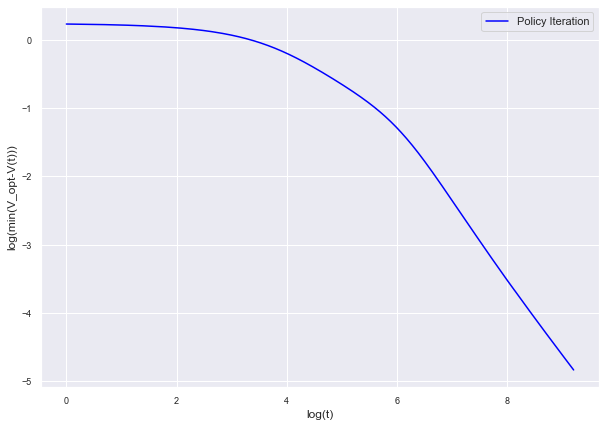

In [22]:
plot_log(min_list_constep,iterations)

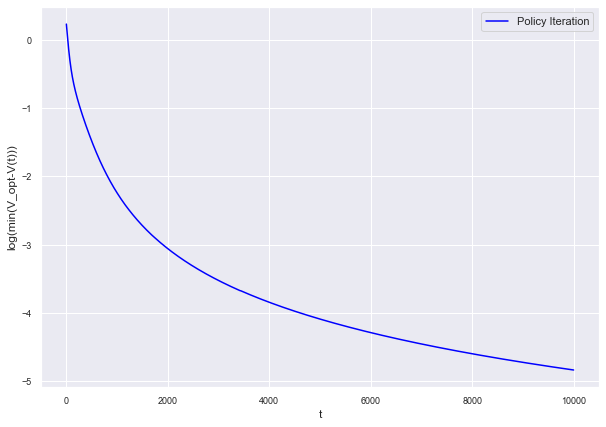

In [23]:
plot_antilog(min_list_constep,iterations)

## Run policy gradient with constant step size : 0.2

In [24]:
iterations=1000
learning_rate=0.2

pi_optimal_constep,V_optimal_constep,min_list_constep=policy_gradient_constant_step(env1,gamma,theta,rho,iterations,learning_rate,V_rho_optimal)

In [25]:
pi_optimal_constep

array([[0.0066741 , 0.9933259 ],
       [0.01156174, 0.98843826],
       [0.99892253, 0.00107747]])

In [26]:
V_optimal_constep

array([[5.14487313],
       [4.16954805],
       [4.58998683]])

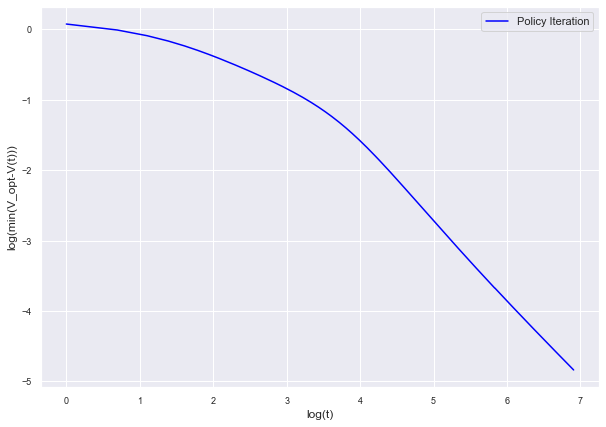

In [27]:
plot_log(min_list_constep,iterations)

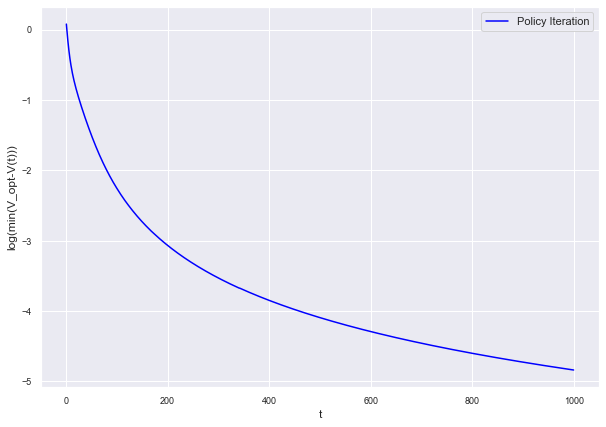

In [28]:
plot_antilog(min_list_constep,iterations)

## Run policy gradient with variant step size : alpha=1


In [29]:
iterations=100
alpha=1
pi_optimal_vstep,V_optimal_vstep,min_list_vstep=policy_gradient_variant_step(env1,gamma,theta,rho,iterations,V_rho_optimal,alpha)

In [30]:
pi_optimal_vstep

array([[0.12547645, 0.87452355],
       [0.30474006, 0.69525994],
       [0.97702843, 0.02297157]])

In [31]:
V_optimal_vstep

array([[4.89886045],
       [4.03646632],
       [4.45854809]])

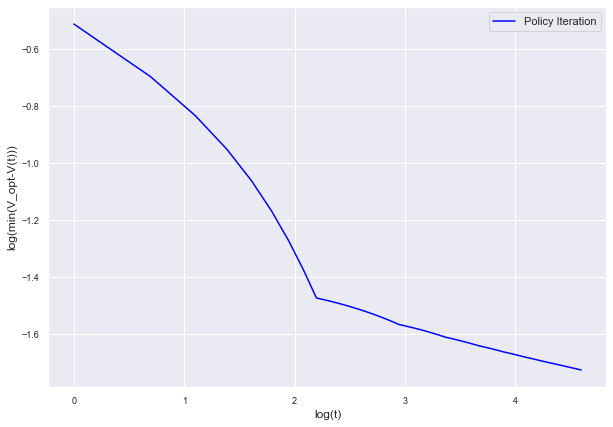

In [32]:
plot_log(min_list_vstep,iterations)

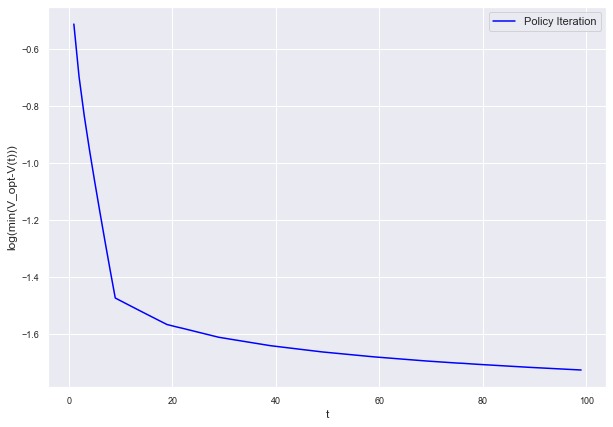

In [33]:
plot_antilog(min_list_vstep,iterations)

## Run policy gradient with variant step size : alpha=0.5


In [34]:
iterations=100
alpha=0.5
pi_optimal_vstep,V_optimal_vstep,min_list_vstep=policy_gradient_variant_step(env1,gamma,theta,rho,iterations,V_rho_optimal,alpha)

In [35]:
pi_optimal_vstep

array([[0.06306588, 0.93693412],
       [0.1372929 , 0.8627071 ],
       [0.98955745, 0.01044255]])

In [36]:
V_optimal_vstep

array([[5.03304367],
       [4.11351081],
       [4.53465755]])

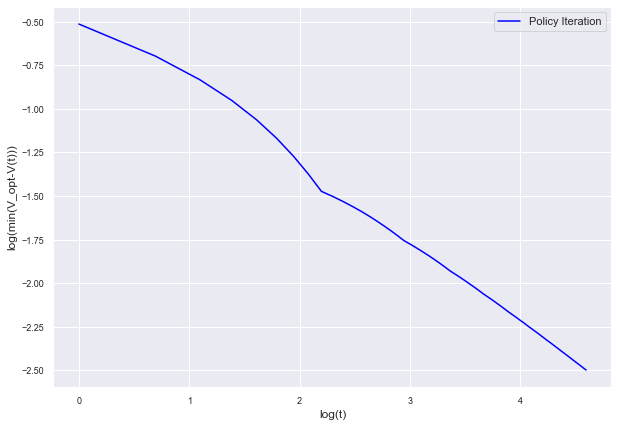

In [37]:
plot_log(min_list_vstep,iterations)

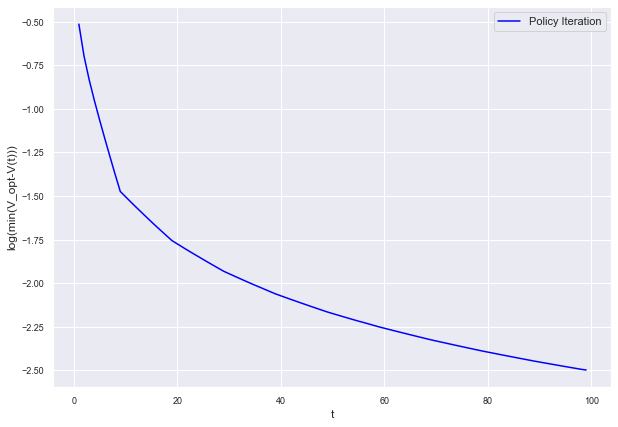

In [38]:
plot_antilog(min_list_vstep,iterations)

## Run policy gradient with variant step size : alpha=2


In [39]:
iterations=100
alpha=2
pi_optimal_vstep,V_optimal_vstep,min_list_vstep=policy_gradient_variant_step(env1,gamma,theta,rho,iterations,V_rho_optimal,alpha)

In [40]:
pi_optimal_vstep

array([[0.15551903, 0.84448097],
       [0.38096072, 0.61903928],
       [0.96984848, 0.03015152]])

In [41]:
V_optimal_vstep

array([[4.83326318],
       [3.99764184],
       [4.41964379]])

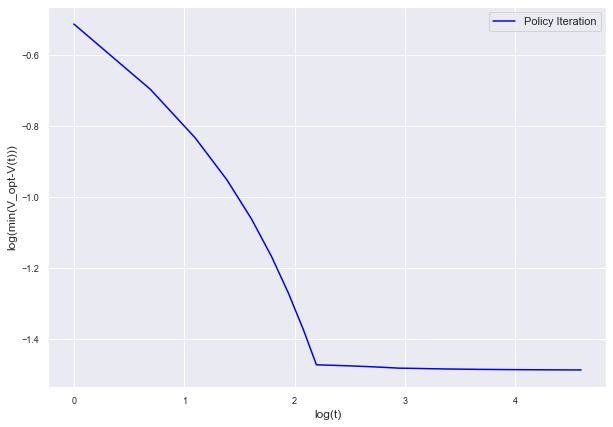

In [42]:
plot_log(min_list_vstep,iterations)

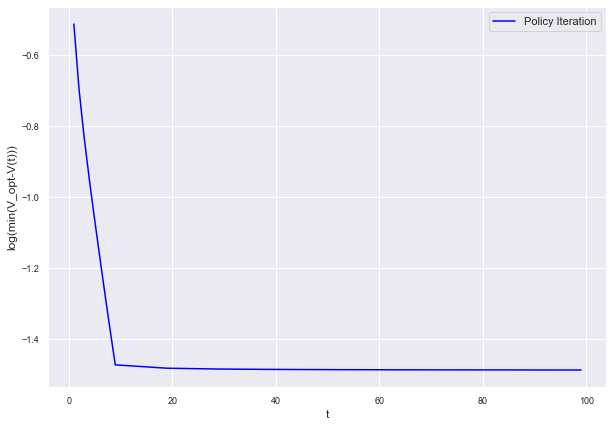

In [43]:
plot_antilog(min_list_vstep,iterations)